# Similarity learning with Covalent

In this workshop, you will learn how to use `covalent` to manage hybrid quantum-classical workflows for the task of similarity learning. Specfically, within the same workflow, we will dispatch a hybrid quantum-classical machine learning (ML) algorithm and a purely classical ML algorithm to recognize *similar* 2x2 pixel images. Later, we will compare the accuracy of the two approaches with a simple test and finish the workshop investigating the *learnt notion of similarity* in the quantum and classical models. Although we study a toy problem, in the present state of the field of Quantum Machine Learning (QML), the workflows introduced here are exemplar real experiments into the effectiveness of similarity learning with QML. 

While performing these experiments, you will be practically introduced the the basic features of `covalent` as well as recieving guidance on how to conduct more complex workflows using remote executors and other plugins. This workshop can then serve as guide to *covalentify* your own workflows, with all the advantages that come with it.

For the structure of this notebook, please see the table of contents below:

# Table of contents

1. [Getting started with Covalent](#launch_cova)

2. [Loading and preparing the training and testing datasets](#load_data)

3. [A quick visual introduction to the datasets](#vis_intro)

4. [Classical Siamese networks](#classical_siamese)

5. [Quantum similarity networks](#quantum_similarity)

6. [A heterogeneous workflow: comparing accuracy scores](#heterogeneous_acc)

7. [Investigating learnt notions of similarity in the classical and quantum networks](#similarity_notion)

8. [Conclusions](#conclusions)

9. [References](#references)

## Getting started with Covalent <a name="launch_cova"></a>

If you have followed the install instructions for this workshop, you should have a `conda` environment with `covalent` (and other dependencies) installed. If you haven't, it should be as easy as

`> conda env create -f environment.yml`

which will create a new `conda` environment called `ieee_covalent`. Now we activate it.

`> conda activate ieee_covalent`

and launch the `covalent` server

`> covalent start`

Provided this was the first time you launched the `Covalent` server, upon navigating to <http://localhost:48008/>, you should see the empty `covalent` GUI like below.

![An empty Covalent GUI.](./images/empty_covalent_gui.png)

Congratulations! You have launched `covalent` successfully. **Keep this tab open in your browser**, we will need it for the rest of the workshop.

Now it's time to learn some simple features while constructing some workflows. First, let's import the dependencies needed for the workshop (including the *vital* `import covalent as ct`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from itertools import cycle

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torch.nn.functional as F

import pennylane as qml

import covalent as ct

import os

## Loading and preparing the training and testing datasets <a name="load_data"></a>

To perform ML, we need data to learn from. It is then useful to locally resolve the path to the relevant datasets shipping with this repository.

In [2]:
base_path = os.getcwd()
pixel_train = "".join([base_path, "/data/pixel_grid/training"])
pixel_test = "".join([base_path, "/data/pixel_grid/testing"])
faces_example = "".join([base_path, "/data/faces/training"])

The classical and quantum versions of the similarity networks used in this workshop interface with `Pytorch`.

![Pytorch logo](./images/pytorch_logo.png)

This means that the data needs to be pre-processed into the correct format. This introduces our first electron (i.e, a task) for completing this job. Notice that the below code cell is simply a python function with a `@ct.electron` decorator.

In [3]:
@ct.electron
def file_to_pytorch_transform(file_root_dir, transform_dims):
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root=file_root_dir)

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize(transform_dims),
                                         transforms.ToTensor()])
    return folder_dataset, transformation

Now with the means of loading `PyTorch` compatible data, we need to perform some pre-processing to make it suitable for the similarity learning task. That is, we need to produce data tuples $(x, \tilde{x}, y_{x, \tilde{x}})$.

$x$ and $\tilde{x}$ are the objects we will judge the similarity between (i.e, images) and $y_{x, \tilde{x}}$ is the label for the ground truth ($y_{x, \tilde{x}}$ = 1 for disimilar objects and $y_{x, \tilde{x}}$ = 0 for similar objects). To do so, we define the utility class `SimilarityModelDataset` (the below code is modified from ref [1]). You will notice that this is *not* an electron, but please stand by...

In [4]:
class SimilarityModelDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In this case, it is useful to call an instance of the above class within its own electron.

In [5]:
@ct.electron
def similarity_learning_dataset(folder_dataset, transformation):
    dataset = SimilarityModelDataset(folder_dataset, transformation)
    return dataset

In a final data-processing step, we create an electron to create a `torch` `DataLoader` object which (amongst other things) is useful in training ML models through many randomized epochs.

In [6]:
@ct.electron
def torch_dataloader(dataset, batch_size, shuffle=True):
    dataloader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size)
    return dataloader

Now, introducing our first lattice (i.e workflow)! We will use it to load all of the datasets used in this Workshop. As can be seen below, lattices are designated simply using the `@ct.lattice` decorator on a function

In [7]:
@ct.lattice
def data_preprocessing_workflow(data_paths, batch_sizes, transforms_vector):
    dataloaders = []
    for data_path, batch_size, dims in zip(data_paths, batch_sizes, transforms_vector):
        # Call all of the data pre-processing electrons
        folder_dataset, transformation = file_to_pytorch_transform(file_root_dir=data_path,
                                                                   transform_dims=dims)
        dataset = similarity_learning_dataset(folder_dataset, transformation)
        dataloader = torch_dataloader(dataset, batch_size)
        dataloaders.append(dataloader)
    return dataloaders

We now dispatch the lattice to the Covalent server.

In [8]:
dispatch_id = ct.dispatch(data_preprocessing_workflow)(data_paths=[pixel_train, pixel_test, faces_example],
                                                       batch_sizes=[8, 1, 1],
                                                       transforms_vector=[(2, 2), (2, 2), (100, 100)])
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
dataloaders = ct_results.result

This will complete fairly instantly. On the GUI, we will be able to inspect the completed workflow. The below will appear

![Your first workflow in the dispatch list](./images/first_lattice_dispatch_list.png)

Simply click on the dispatch ID to be presented with the workflow transport graph. It should appear as below

![The data pre-processing workflow](./images/data_preprocessing_graph.png)

In the GUI, you will see that there are many features for navigating this graph using the tool bar. You should take some time now to play around with these.

Above all, you should notice **three separate** graphs (i.e, groups of electrons not connected with a line). This means that `covalent` has recognized them as independent computations. By default such independent calculations are run in parallel using `dask` using an out-of-the-box executor (known as the `dask` executor).

![Dask logo](./images/dask_logo.png)

By simply adding decorators to functions we have autoparallelized our workflow, neat! If you ever which to view the state of the local `dask` cluster, navigate to the `dask` GUI at <http://localhost:8787/status>.

What other things does Covalent do by default? It can tell you how long a workflow took to complete

In [9]:
print("Workflow took %.5f seconds to complete" % ((ct_results.end_time - ct_results.start_time).total_seconds()))

Workflow took 3.18862 seconds to complete


One more useful feature of `covalent` before we move on. In the above workflow, we return only one thing: the list of `dataloader` objects. What about if I wanted access to intermediate objects (like the first dataset object for instance)? With `covalent`, this information is *not lost*. All intermediate results are serialized and can be retrieved using 

`res = ct_results.get_all_node_outputs()`

One can scroll through the dictionary `res` until the correct node is found. It can be deserialized to the original result object using the `get_deserialized()` method.

For other useful features, please see the RTD page <https://covalent.readthedocs.io/en/stable/>

## A quick visual introduction to the datasets <a name="vis_intro"></a>

Let's open some of the datasets from the workflow we just ran, starting with the testing dataset of 2x2 pixel grids

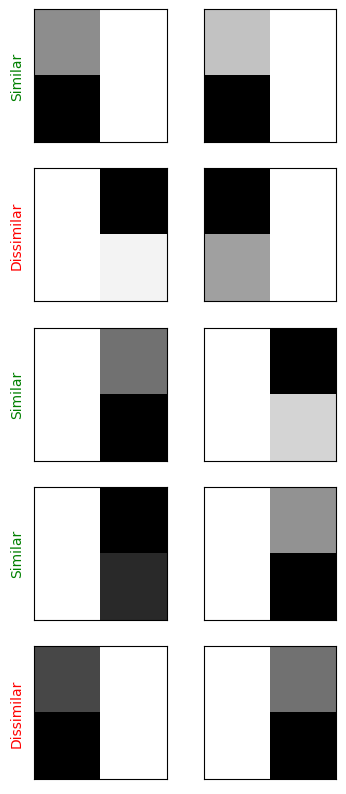

In [10]:
# Display a couple of items from the training dataset
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=[4, 10])

iterarable_pixels = iter(dataloaders[1])
for i in range(5):
    # Pixels first
    x1_pixel, x2_pixel, label_pixel = next(iterarable_pixels)
    axs[i, 0].imshow(x1_pixel[0, 0, :, :], cmap="Greys")
    axs[i, 1].imshow(x2_pixel[0, 0, :, :], cmap="Greys")
    axs[i, 0].set_xticks([]); axs[i, 1].set_xticks([])
    axs[i, 0].set_yticks([]); axs[i, 1].set_yticks([])
    # Display label
    if label_pixel == 1:
        axs[i, 0].set_ylabel('Dissimilar', color="red")
    else:
        axs[i, 0].set_ylabel('Similar', color="green")

It can be seen that images labelled as **similar** ($y_{x \tilde{x}} = 0$) are those sharing a left or right side with zeroed-out pixels. 

Those which are **dissimilar** ($y_{x \tilde{x}} = 1$) have zeroed-out pixels on opposite sides.

This may seem a little abstract. What does this all mean in the context of a more realistic dataset? Let's take a look at some faces...

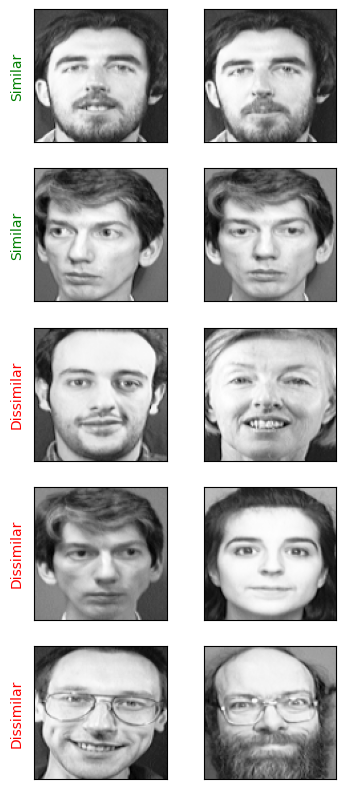

In [11]:
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=[4, 10])
iterable_faces = iter(dataloaders[2])
for i in range(5):
    # Faces second
    x1_face, x2_face, label_face = next(iterable_faces)
    axs[i, 0].imshow(x1_face[0, 0, :, :], cmap="Greys_r")
    axs[i, 1].imshow(x2_face[0, 0, :, :], cmap="Greys_r")
    axs[i, 0].set_xticks([]); axs[i, 1].set_xticks([])
    axs[i, 0].set_yticks([]); axs[i, 1].set_yticks([])

    # Display label
    if label_face == 1:
        axs[i, 0].set_ylabel('Dissimilar', color="red")
    else:
        axs[i, 0].set_ylabel('Similar', color="green")

Here, things are a little more obvious. If the image is of the same person, they are **similar** ($y_{x \tilde{x}} = 0$). If they display a different person, they are **dissimilar** ($y_{x \tilde{x}} = 1$). It is now clear that an algorithm capable of performing such distinctions is useful in areas like facial recognition.

Anyways, let's proceed with our 2x2 pixel example and devise a classical and quantum algorithm capable of learning these notions of similarity. Let's start classical!

## Classical Siamese networks <a name="classical_siamese"></a>

A classical Siamese network tackles the similarity learning task by jointly training twin (think Siamese...) neural networks using a **contrastive loss**. A typical layout of a Siamese network is shown below.

![A schematic of a classical Siamese network.](./images/siamese_network.png)

Source: <https://www.youtube.com/watch?v=4S-XDefSjTM>

While such networks usually involve dimension reduction of the image to create a low-dimensional latent space (via something like `torch.nn.MaxPool2d`), we are already working with 2x2 pixel grayscale images so we skip this part. 

Lets create a `PyTorch` network involing convolutional and linear layers (the below code is modified from ref [1]).

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True),
            # Maxpooling here if image was larger dimensions...
            
            nn.Conv2d(2, 4, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True),
            # Maxpooling here if image was larger dimensions...

            nn.Conv2d(4, 8, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True)
        )

        # Setting up the Sequential of Fully Connected linear Layers
        self.fc1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the raw (pre sigmoidal) similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

We now have a network which outputs a latent vector upon insertion of an image. Now, in a Siamese network, we require comparison of the latent vector upon insertion of two different images $x$ and $\tilde{x}$. This defines the contrastive loss, explained simply in Ref [1].

In [13]:
class ClassicalContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ClassicalContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    

        loss_contrastive = 2*(torch.sigmoid(loss_contrastive) - 0.5) # Mean square loss is positive. Rescale in 0 1
        return loss_contrastive

and a corresponding electron to create a `ClassicalContrastiveLoss` instance

In [14]:
@ct.electron
def classical_contrastive_loss(margin=2):
    contrastive_loss = ClassicalContrastiveLoss(margin)
    return contrastive_loss

We're nearly there! We need an electron to train the network.

In [15]:
@ct.electron
def train_classical_siamese_network(train_dataloader, torch_optim, lr,
                                    loss_function, epochs, print_intermediate=False):
    
    # Create network instance here
    network = SiameseNetwork()
    optimizer = torch_optim(network.parameters(), lr)
    loss_history = [] 

    # Outer training loop
    for epoch in range(epochs):

        # Iterate over batches
        for i, (img1, img2, label) in enumerate(train_dataloader, 0):

            # Images and labels
            img1, img2, label = img1.cpu(), img2.cpu(), label.cpu()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = network.cpu()(img1, img2)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = loss_function(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Loss appended at the end of each batch
            loss_history.append(loss_contrastive.item())

            # Every 10 epochs print out the loss
        if print_intermediate:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
    return network, loss_history

an electron to get the simlarity between unseen images and return a prediction.

In [16]:
@ct.electron
def get_similarity(x1, x2, trained_net):
    output1, output2 = trained_net(x1.cpu(), x2.cpu())
    euclidean_distance = F.pairwise_distance(output1, output2)
    scaled_dist = 2*(torch.sigmoid(euclidean_distance) - 0.5)
    prediction = torch.round(scaled_dist)
    return scaled_dist, prediction

and, finally, an electron to run testing

In [17]:
@ct.electron
def get_testing_results(dataloader_test, trained_net, num_dat=None):
    results = []
    iterable = iter(dataloader_test)
    if num_dat is None:
        num_dat = len(dataloader_test.dataset)
    for i in range(num_dat):
        x1, x2, label = next(iterable)
        scaled_dist, prediction = get_similarity(x1, x2, trained_net)
        results.append([label.item(), prediction.item(), scaled_dist.item()])
    return results

Now it's time to construct a simple exemplar workflow. We shall load the training and testing data, perform preprocessing, train the network and see how predictions line up with the ground truth for 5 elements of the testing dataset.

In [18]:
@ct.lattice
def classical_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr, print_intermediate, test_num_dat):

    # Grab datasets using the sublattice from before
    dataloader_train, dataloader_test = data_preprocessing_workflow(data_paths=[train_path, test_path],
                                                                    batch_sizes=[8, 1],
                                                                    transforms_vector=[(2, 2), (2, 2)])

    # Siamese network initialization
    contrastive_loss = classical_contrastive_loss()

    # Train the network
    trained_net, loss_history = train_classical_siamese_network(torch_optim=pytorch_optimizer,
                                                               train_dataloader=dataloader_train,
                                                               loss_function=contrastive_loss,
                                                               epochs=epochs,
                                                               print_intermediate=print_intermediate, lr=lr)
    
    # Perform predictions on testing data with the trained network
    results = get_testing_results(dataloader_test, trained_net, num_dat=test_num_dat)
    
    return results, loss_history, trained_net

We dispatch to the `covalent` server in the same way as before

In [19]:
dispatch_id = ct.dispatch(classical_workflow)(train_path=pixel_train,
                                              test_path=pixel_test,
                                              train_batch=8,
                                              pytorch_optimizer=torch.optim.Adam,
                                              epochs=5,
                                              lr=0.005,
                                              print_intermediate=False,
                                              test_num_dat=5)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

Check for the success of the workflow on the GUI. Once completed, the GUI should display the below

![The classical learning workflow](./images/classical_training_graph.png)

In [20]:
results, loss_history, trained_net = ct_results.result

Let's check out how well the (small number of epochs) was able to train the net

Text(0, 0.5, 'Classical loss')

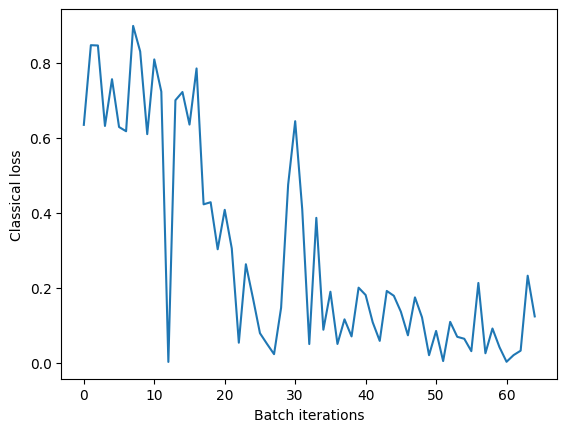

In [21]:
plt.plot(loss_history)
plt.xlabel('Batch iterations')
plt.ylabel('Classical loss')

and how successful the trained net was able to predict class labels

In [22]:
for i, res in enumerate(results):
    # first element ground truth label, second element predicted label.
    if res[0] == res[1]:
        print('Got test %d correct. Predicted label = %d, truth label = %d' % (i, res[1], res[0]))

Got test 0 correct. Predicted label = 0, truth label = 0
Got test 1 correct. Predicted label = 0, truth label = 0
Got test 2 correct. Predicted label = 0, truth label = 0
Got test 3 correct. Predicted label = 1, truth label = 1


## Quantum similarity networks <a name="quantum_similarity"></a>

Based on the paper by Radha and Jao (see ref [2]), there exist ways to learn similarity using variational quantum circuits in a way fairly analogous to classical neural nets. We use the variation suggested in the paper as shown in the unitary diagram below:

![A schematic of one type of Quantum similarity network.](./images/quantum_net.png)

Specifically, we shall work with a 5 qubit ($n=5$) system and set the number of measured qubits to $m=2$. We proceed with $V_{\eta}(\tilde{x}) = U^{\dagger}_{\eta}(\tilde{x})$.

Throughout this section, we use the `Pennylane` software package for building quantum circuits and their subsequent optimization. 
<img src="./images/pennylane_logo.png"  width="250" height="200">

This is since the interface to `PyTorch` will later make comparison between classical and quantum methods easier.

We begin by specifiying the backend quantum device used in the quantum net

In [23]:
# dev = qml.device('lightning.qubit', wires=5)
dev = qml.device('default.qubit', wires=5)

The above is a local quantum circuit simulator since for the purposes of this workshop, we are working on our own local classical computers. This can of course be different for a real heterogeneous workflow as we will allude to later on.

As a slight technical hitch, depending on your local machine, the above simulator may not work. If it doesn't, please change the above code cell to:

`dev = qml.device('default.qubit', wires=5)`

This will lead to the same results as `lightning.qubit`, but won't be as fast!

Now, let's define our similarity circuit as in the image above.

In [24]:
@ct.electron
@qml.qnode(dev, interface='torch')
def similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=qml.QAOAEmbedding, measure_bits=2):
    # Basically a kernel
    ansatz(features=x1, weights=alpha1, wires=wires)
    qml.adjoint(ansatz)(features=x2, weights=alpha2, wires=wires)
    # Measure only first measure_bits qubits.
    return [qml.expval(qml.PauliZ(i)) for i in range(measure_bits)]

Notice that it's totally fine to doubly decorate a function. Notice also that the form of $U$ is set by default to `qml.QAOAEmbedding`. An exemplar circuit corresponding to this choice for four qubits is shown below

![QAOA embedding from Pennylane](./images/qaoa_embedding.png)

More information can be found at <https://docs.pennylane.ai/en/stable/code/api/pennylane.QAOAEmbedding.html>

We now implement an electron for the quantum cost function. Simply, the QAOA circuits are embeeded with all 4 pixels from the two 2x2 pixel grids and the distance function for *one pair of images* is calculated using the expected value of the Pauli-z operator for both of the `measure_bits`. This is then taken on average over a batch size and rescaled in the interval 0-1. This distance is then inserted into the same form of contrastive loss as was done for the classical Siamese network.

In [25]:
@ct.electron
def quantum_cost(batch, alpha1, alpha2, wires, similarity_circuit, measure_bits=2):
    x1_batch, x2_batch, label_batch = batch
    batch_size = len(x1_batch)
    all_costs = torch.zeros(batch_size)
    for i in range(batch_size):

        x1 = torch.flatten(x1_batch[i]) # embedding requires flat tensor
        x2 = torch.flatten(x2_batch[i])
        label = label_batch[i]

        expecs = similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=qml.QAOAEmbedding, measure_bits=measure_bits)
        dist = (torch.mean(expecs) + 1)/2 # Now in 0 - 1
        loss_contrastive = (1-label) * torch.pow(dist, 2) +\
                       (label) * torch.pow(torch.clamp(0.9 - dist, min=0.0), 2)
        all_costs[i] = loss_contrastive
    avg_loss = torch.mean(all_costs)
    return avg_loss

Some more electrons! We need to specify the initial angles of the ansatz. We do this randomly.

In [26]:
@ct.electron
def get_random_init_params(n_qubits, layers, ansatz=qml.QAOAEmbedding):
    alpha1 = torch.tensor(np.random.uniform(size=ansatz.shape(layers, n_qubits)), requires_grad=True)
    alpha2 = torch.tensor(np.random.uniform(size=ansatz.shape(layers, n_qubits)), requires_grad=True)
    return alpha1, alpha2

Now, using the `pennylane`-`PyTorch` interface, we implement a training electron. We see now that the classical and quantum networks can be trained with the same choice of optimizer!

In [27]:
@ct.electron
def train_quantum_net(lr, init_params, dataloader_train, batch_cost_func, similarity_circuit,
                      measure_bits, epochs, pytorch_optimizer, print_intermediate=False):

    opt = pytorch_optimizer(init_params, lr=lr)
    dataiter = iter(dataloader_train)
    alpha1, alpha2 = init_params

    def closure():
        opt.zero_grad()
        loss = batch_cost_func(next(dataiter), alpha1, alpha2, 
                               similarity_circuit=similarity_circuit,
                               wires=dev.wires, measure_bits=measure_bits)
        loss.backward()
        return loss
    
    loss_history = [] 
    for epoch in range(epochs):
        dataiter = iter(dataloader_train)
        for i in range(len(dataloader_train)):
            loss = opt.step(closure)
            loss_history.append(loss.item()) 
        if epoch % 10 == 0 and print_intermediate:
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
    return loss_history, opt

Two more electrons. The first is for calculating the distance function (without the full contrastive loss) and the second to make a label prediction based upon the distance.

In [28]:
@ct.electron
def get_quantum_prob(x1, x2, label, alpha1, alpha2, wires, similarity_circuit, ansatz=qml.QAOAEmbedding, measure_bits=2):
    x1 = torch.flatten(x1) # embedding requires flat tensor
    x2 = torch.flatten(x2)
    expecs = similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=ansatz, measure_bits=measure_bits)
    dist = (torch.mean(expecs) + 1)/2 # Now in 0 - 1
    return dist

@ct.electron
def quantum_predict(quantum_prob):
    return torch.round(quantum_prob)

The above two electrons are now used within an electron to get all the testing results

In [29]:
@ct.electron
def get_test_results_quantum(dataloader_test, opt_params, prob_func, predict_func, wires, measure_bits, num_dat=None):
    # pass a dataloader with 1 batch size to cycle through testing
    alpha1, alpha2 = opt_params
    iterable = iter(dataloader_test)
    results = []
    if num_dat is None:
        num_dat = len(dataloader_test.dataset)
    for i in range(num_dat):
        x1, x2, label = next(iterable)
        x1 = torch.flatten(x1) # embedding requires flat tensor
        x2 = torch.flatten(x2)

        prob = prob_func(x1, x2, label, alpha1, alpha2, wires, similarity_circuit, ansatz=qml.QAOAEmbedding, measure_bits=2)
        prediction = predict_func(prob)
        results.append([label.item(), prediction.item(), prob.item()])
    return results

We can now create the quantum workflow which, as you will notice, shares many similarities with the classical one!

In [30]:
@ct.lattice
def quantum_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr, print_intermediate, test_num_dat):

    # Grab datasets using the sublattice from before
    dataloader_train, dataloader_test = data_preprocessing_workflow(data_paths=[train_path, test_path],
                                                                    batch_sizes=[8, 1],
                                                                    transforms_vector=[(2, 2), (2, 2)])

    # Get intial parameters for quantum net. We hardcode the 5 qubit 2 layer QAOA ansatz.
    alpha1, alpha2 = get_random_init_params(5, 2)

    # pass relevant electron functions to training routine. Measure_bits=2 is also hardcoded
    loss_history, opt = train_quantum_net(lr=lr, init_params=[alpha1, alpha2],
                                          dataloader_train=dataloader_train,
                                          batch_cost_func=quantum_cost, # is an electron function
                                          similarity_circuit=similarity_circuit, # is an electron function
                                          measure_bits=2, epochs=epochs,
                                          pytorch_optimizer=pytorch_optimizer,
                                          print_intermediate=False)
    results = get_test_results_quantum(dataloader_test, opt.param_groups[0]['params'],
                                       prob_func=get_quantum_prob, 
                                       predict_func=quantum_predict,
                                       wires=dev.wires,
                                       measure_bits=2, num_dat=test_num_dat)
    return results, loss_history, opt

We now dispatch the `quantum_workflow` lattice and await the results.

In [31]:
dispatch_id = ct.dispatch(quantum_workflow)(train_path=pixel_train,
                                            test_path=pixel_test,
                                            train_batch=8,
                                            pytorch_optimizer=torch.optim.Adam,
                                            epochs=5,
                                            lr=0.05,
                                            print_intermediate=False,
                                            test_num_dat=5)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

One again, we can examine the workflow graph on the GUI. It should appear as below

![The quantum learning workflow](./images/quantum_training_graph.png)

Now we'll pull the results back from the `covalent` server

In [32]:
results, loss_history, trained_opt = ct_results.result

look at the training loss and the success of testing as we did for the classical Siamese network

Text(0, 0.5, 'Quantum loss')

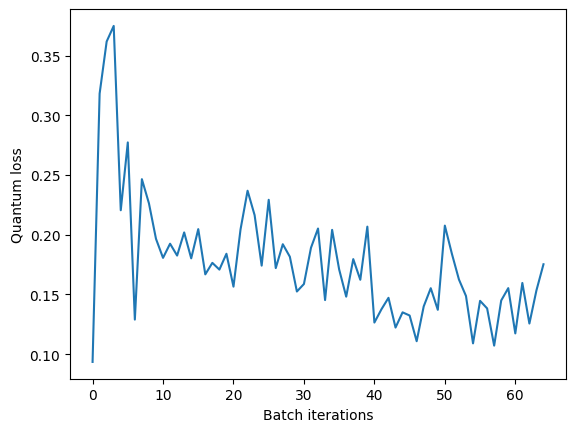

In [33]:
plt.plot(loss_history)
plt.xlabel("Batch iterations")
plt.ylabel("Quantum loss")

In [34]:
for i, res in enumerate(results):
    # first element ground truth label, second element predicted label.
    if res[0] == res[1]:
        print('Got test %d correct. Predicted label = %d, truth label = %d' % (i, res[1], res[0]))

Got test 0 correct. Predicted label = 1, truth label = 1
Got test 1 correct. Predicted label = 0, truth label = 0
Got test 2 correct. Predicted label = 1, truth label = 1
Got test 3 correct. Predicted label = 1, truth label = 1
Got test 4 correct. Predicted label = 0, truth label = 0


## A heterogeneous workflow: comparing accuracy scores <a name="heterogeneous_acc"></a>

We've laid down the basics of the classical and quantum networks for similarity learning. From now on, we will perform some meaningful comparison with the help of `covalent`. As a side note, although the title of this section suggests otherwise, this section does not comprise *the first* heterogenous workflow of the tutorial. In the quantum workflow, we already went heterogeneous since the quantum circuit parameters were optimized with a classical optimization routine. 

Anyways, a first comparison is to look at the accuracy score of a realistically trained classical and quantum model. We will need a simple accuracy score electron for this.

In [35]:
@ct.electron
def get_accuracy_score(results_tuples):
    # Process the (label, prob, prediciton) tuple and return an accuracy percentage
    correct_counter = 0
    for result in results_tuples:
        if result[0] == result[1]: # Label matches prediction
            correct_counter += 1
        else:
            continue
    return 100*correct_counter/len(results_tuples)

Now, we simply re-use the classical and quantum workflows from before (using them as sublattices) to define a `quantum_classical_workflow`. Note that this does include redundantly loading the testing and training datasets twice, but this is by no means a bottleneck in performance.

In [36]:
@ct.lattice
def quantum_classical_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr_c, lr_q, print_intermediate):

    # Run the classical sublattice
    results_classical, loss_history_classical, trained_net_c = \
         classical_workflow(train_path=pixel_train,
                            test_path=pixel_test,
                            train_batch=train_batch,
                            pytorch_optimizer=pytorch_optimizer,
                            epochs=epochs,
                            lr=lr_c,
                            print_intermediate=print_intermediate,
                            test_num_dat=None)

    # Run the quantum sublattice
    results_quantum, loss_history_quantum, trained_opt_q = \
         quantum_workflow(train_path=train_path,
                          test_path=test_path,
                          train_batch=train_batch,
                          pytorch_optimizer=pytorch_optimizer,
                          epochs=epochs,
                          lr=lr_q,
                          print_intermediate=print_intermediate,
                          test_num_dat=None)

    # Calculate the accuracy scores
    acc_classical = get_accuracy_score(results_classical)
    acc_quantum = get_accuracy_score(results_quantum)
    return (acc_classical, acc_quantum, trained_net_c, trained_opt_q,
            loss_history_classical, loss_history_quantum, results_quantum, results_classical)

To make this more realistic, we up the epochs in training from 5 to 25 and perform testing on the entire testing dataset. **Expect the below to take a few minutes to complete.**

In [37]:
# Expect this to take a few minutes (~2 minutes on an M1 mac with default.qubit)
dispatch_id = ct.dispatch(quantum_classical_workflow)(train_path=pixel_train,
                                                      test_path=pixel_test,
                                                      train_batch=8,
                                                      pytorch_optimizer=torch.optim.Adam,
                                                      epochs=25,
                                                      lr_q=0.05,
                                                      lr_c=0.0005,
                                                      print_intermediate=False)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
print("Quantum-classical workflow took %.5f seconds to complete" % ((ct_results.end_time - ct_results.start_time).total_seconds()))

Quantum-classical workflow took 79.30858 seconds to complete


Unlike the other workflows (which should take very little time to compute), if you go to the GUI, you should be able to see the flow progressing through the transport graph in real-time. Once completed, the graph should look like the below

![The heterogeneous training workflow](./images/quantum_classical_training_graph.png)

In [38]:
acc_classical, acc_quantum, trained_net_c, trained_opt_q, loss_history_classical,\
     loss_history_quantum, results_quantum, results_classical = \
     ct_results.result

Let's now examine the accuracy scores from each network

In [39]:
print("Accuracy score for classical Siamese network:", acc_classical, "%")
print("Accuracy score for quantum similarity network:", acc_quantum, "%")

Accuracy score for classical Siamese network: 94.0 %
Accuracy score for quantum similarity network: 76.0 %


These are interesting insights, however, (and convince yourself of this if you have the time), these resutls will vary upon different random initializations of network parameters and the effectiveness of the following training. To make any real conclusions of the effectiveness of a different method *on this dataset* we would have to run very many training instances using different random parameter initializations. This is beyond the scope of this workshop.

Let's now look at the loss functions beside one another

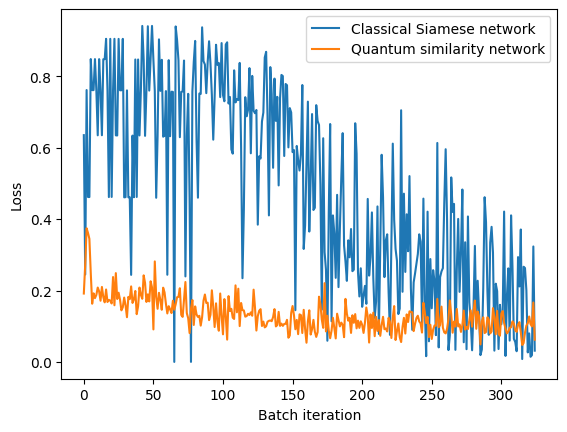

In [40]:
plt.plot(loss_history_classical, label="Classical Siamese network")
plt.plot(loss_history_quantum, label="Quantum similarity network")
plt.xlabel('Batch iteration')
plt.ylabel('Loss')
plt.legend()

Do you see any distinct difference in the training behaviour?

You may be asking yourself by now "why did I do all of this with `covalent`?" Well, apart from default autoparallelization on the local `dask` cluster and other organizational benefits mentioned in the first section of this workshop, within `covalent`, there is the possibility of making this workflow **truly heterogeneous**.

That is, presently, everything is happening on our local (classical) machine but it need not be this way. Some electrons can be sent to classical compute (locally or in the cloud) while others can be sent to cloud quantum compute resources. Although we do not explicitly show such workflows executing in this workshop (you would need to set up billing and credentials with cloud compute providers etc.), we can show how easy it is within this markdown cell. 

It is often as simple as passing the the correct `executor` to an electron. Want to run a key compute kernel with classical HPC? An electron can be sent to an `Amazon EC2` instance

```python
executor = ct.executor.EC2Executor(
    username="ubuntu",
    ssh_key_file="/home/user/.ssh/ssh_key.pem",
    key_name="ssh_key"
    instance_type="t2.micro",
    volume_size="8GiB",
    ami="amzn-ami-hvm-*-x86_64-gp2",
    vpc="vpc-07bdd9ca40c4c50a7",
    subnet="subnet-0a0a7f2a7532383c3",
    profile="custom_user_profile",
    credentials_file="~/.aws/credentials"
)

@ct.electron(executor=executor)
def my_custom_task(x, y):
    return x + y
```

And with a little more effort, sent to quantum resources from `Amazon Braket` using our executor in interface with `Pennylane`

```python
@ct.electron(executor="braket")
def my_hybrid_task(num_qubits: int, shots: int):
    import pennylane as qml

    # These are passed to the Hybrid Jobs container at runtime
    device_arn = os.environ["AMZN_BRAKET_DEVICE_ARN"]
    s3_bucket = os.environ["AMZN_BRAKET_OUT_S3_BUCKET"]
    s3_task_dir = os.environ["AMZN_BRAKET_TASK_RESULTS_S3_URI"].split(s3_bucket)[1]

    device = qml.device(
        "braket.aws.qubit",
    device_arn=device_arn,
    s3_destination_folder=(s3_bucket, s3_task_dir),
    wires=num_qubits,
    shots=shots,
    parallel=True,
    max_parallel=4
    )

    @qml.qnode(device)
    def circuit():
        # Define the circuit here
```

These electrons can then be dispatched within the same lattice and would constitute a true heterogeneous workflow.

For more information, check out the plugins page on RTD <https://covalent.readthedocs.io/en/stable/plugins.html>

## Investigating learnt notions of similarity in the classical and quantum networks <a name="similarity_notion"></a>

Anyways, back to our ML experiments. So far, we trained (and tested) quantum and classical similarity networks to learn that left-sided and right-sided 2x2 pixel grids were disimilar but when sides are shared they are similar. But what about all of the inbetween pixel grids? 

I.e, what do our trained networks think about pixel grids which are mostly right-sided and little bit left sided? What about grids which are equally left and right sided? 

Let us now investigate these *learnt notions of similarity* with a simple test.

In [41]:
@ct.electron
def generate_left_right_transition(num_images):
    image_pairs = []
    left_image = torch.tensor([[[1.0, 0],
                               [1.0, 0]]], requires_grad=False, dtype=torch.float32)
    for intensity in torch.tensor(np.linspace(0, 1, num_images), requires_grad=False, dtype=torch.float32):
        image = torch.tensor([[[1.0-intensity, intensity],
                              [1.0-intensity, intensity]]], requires_grad=False, dtype=torch.float32)
        image_pairs.append([left_image, image, 2]) # 2 is the label; different on purpose to previous
    return image_pairs

The above electron generates pairs of pixel grids. The first element of the pair is *always* fully left-sided while the second element of the pair slowly becomes more and more right sided.

We display the second element of 20 pairs below

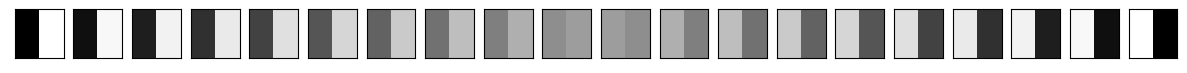

In [42]:
image_pairs = generate_left_right_transition(20)
fig, axs = plt.subplots(1, 20, figsize=[15, 2])
for i, image_pair in enumerate(image_pairs):
    axs[i].imshow(image_pair[1][0], vmin=0, vmax=1, cmap="Greys")
    axs[i].set_yticks([]); axs[i].set_xticks([])

Making use of the trained classical and quantum nets from before, we now set up a heterogeneous workflow to score each of the pairs

In [43]:
@ct.lattice
def similarity_experiment(num_images, trained_net_c, trained_opt_q):
    image_pairs = generate_left_right_transition(num_images)
    dataloader_test = torch_dataloader(image_pairs, shuffle=False, batch_size=1)
    results_c = get_testing_results(dataloader_test, trained_net)
    results_q = get_test_results_quantum(dataloader_test, trained_opt_q.param_groups[0]['params'],
                                         prob_func=get_quantum_prob, 
                                         predict_func=quantum_predict,
                                         wires=dev.wires,
                                         measure_bits=2)
    return results_c, results_q
    

and dispatch it

In [44]:
dispatch_id = ct.dispatch(similarity_experiment)(num_images=20, trained_net_c=trained_net_c, trained_opt_q=trained_opt_q)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
results_c, results_q = ct_results.result

Which, in the GUI, should produce a comparatively simpler workflow to the previous one

<img src="./images/similarity_notion_compare_graph.png" alt="drawing" width="500"/>

<!-- ![The similarity notion comparison workflow](./images/similarity_notion_compare_graph.png) -->

we now plot the similarity score for each of the pixel grid pairs

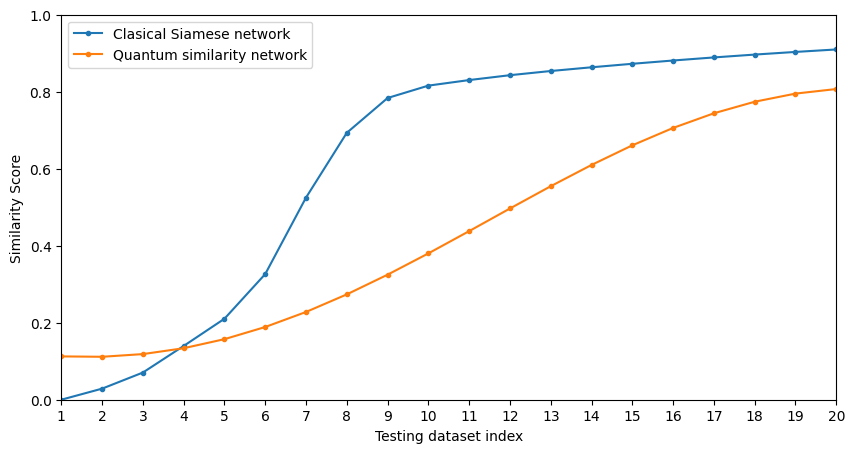

In [45]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, 21), [results_c[i][2] for i in range(len(results_c))], '.-', label="Clasical Siamese network")
plt.plot(range(1, 21), [results_q[i][2] for i in range(len(results_q))], ".-", label="Quantum similarity network")
plt.ylim(0, 1); plt.xlim(1, 20)
plt.xticks(range(1, 21))
plt.ylabel('Similarity Score')
plt.xlabel('Testing dataset index')
plt.legend()

The above similarity score curves will very likely look different for the quantum and classical cases (they do at least in the pre-executed notebook). As this is a current research topic, we leave it to you to explain/rationalize these differences! Have a discussion with your neighbour perhaps?

## Conclusions <a name="conclusions"></a>

You have now reached the end of the workshop material. Well done! Let's take the time to summarize what we have learned.

1. By *functionalizing* our code and using two decorators (`@ct.electron` and `@ct.lattice`), we can use `covalent` to manage and schedule heterogeneous workflows in machine learning and beyond.

2. With no extra effort, we get out-of-the-box `dask` parallelization, a clean GUI and general housekeeping (autosaving of intermediate results etc).

3. With little added effort, we can send different electrons to different classical and quantum compute resources in the cloud using our plugins library <https://covalent.readthedocs.io/en/stable/plugins.html>

4. All of these things together allow for efficient and organized structuring of ML/QML research projects as demonstrated by our similarity learning experiments.

**How you could use covalent in your research?**

## References <a name="references"></a>

[1] Siamese Network in Pytorch with application to face similarity, <https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/>

[2] Radha, S.K. and Jao, C., 2022. Generalized quantum similarity learning. arXiv preprint <https://arxiv.org/abs/2201.02310>